<a href="https://colab.research.google.com/github/PaolaGAPI/Analyze-audio-signals-to-determine-the-music-Genre/blob/main/CNN_for_Music_Genre_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CNN Model for Music Genre Classification:

Una red neuronal convolucional (ConvNet/CNN) es un algoritmo de aprendizaje profundo que puede tomar una imagen de entrada, asignar importancia (pesos) a varias características en la imagen y poder diferenciar una de otra. CNN trabaja con convolución y agrupación en secuencia alterna en la red neuronal. Entonces, ¿por qué usar CNN en la clasificación de géneros? CNN, como se discutió antes, está especializado en el reconocimiento de características de imagen, asi pues como mencionamos anteriormente el espectrograma que representa el MFCC junto con el tiempo y la frecuencia será la entrada del modelo CNN.


En primer lugar, importamos algunas bibliotecas necesarias. Librosa es un paquete útil para manejar archivos de audio en Python, ya que proporciona no solo E/S, sino también varias transformaciones y extracción de características de audio, incluido MFCC.


In [ ]:
!pip install librosa
!pip install tensorflow
!pip install keras
!pip install sklearn
!pip install scipy
!pip install pickle


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import librosa as lb
import librosa.display
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Puede escribir hasta 20 GB en el directorio actual (/kaggle/working/) que se conserva como salida cuando crea una versión usando "Guardar y ejecutar todo"
# También puede escribir archivos temporales en /kaggle/temp/, pero no se guardarán fuera de la sesión actual

import matplotlib.pyplot as plt
import scipy
import librosa
import librosa.display
import IPython.display as ipd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras
import pickle # model pickling for future use




In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import librosa as lb
import librosa.display
import os

import IPython
import IPython.display as ipd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, losses, regularizers
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import visualkeras

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

## The Dataset - GTZAN

- Instancias (m): 1.000
- Duración de la secuencia (por instancia): 30 segundos
- Etiquetas: 10 (Blues, Clásica, Country, Disco, Hip hop, Jazz, Metal, Pop, Reggae, Rock)

Preparación del conjunto de datos.

### Pasos
1. Crea el conjunto de datos
2. Ajuste la CNN al conjunto de datos
3. Evaluar el desempeño

### Creando el conjunto de datos
Según los diferentes recursos que encuentro en línea (Kaggle y algunas publicaciones de blog), parece que el camino a seguir es extraer características significativas de los datos, darles forma para que compartan dimensiones y construir un tensor a partir de ellos.
La característica más interesante fue el Mel-Spectogram
  

## 1. Setup, Data, Feature Engineering

# Loading Datasets:

In [ ]:
# Setup: path, one-hot vector for the labels
# ----------------

path = '/content/drive/MyDrive/Universidad/AI/Final Project/Data/genres_original/'
labels = [f.name for f in os.scandir(path) if f.is_dir()]

# One-hot vector for the labels
indices = [i for i in range(len(labels))]
depth = len(labels)
oh = tf.one_hot(indices, depth)
oh_dict = {label:np.array(oh[i,:]) for i, label in enumerate(labels)}

print(labels)
for k, v in oh_dict.items():
    print(k,v)

n_files = 0
for folder in labels:
    files = os.listdir(path+folder)
    for file in files:
        if file.split('.')[-1] == 'wav':
            n_files += 1
print(f'n_files: {n_files}')

['country', 'classical', 'blues', 'rock', 'reggae', 'pop', 'metal', 'jazz', 'hiphop', 'disco']
country [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
classical [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
blues [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
rock [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
reggae [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
pop [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
metal [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
jazz [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
hiphop [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
disco [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
n_files: 1000


In [ ]:
# Cargando conjunto de datos
# tenemos 2 CSV aquí, uno que contiene funciones para un archivo de audio de 30 segundos, media y varianza para las funciones diferenciales que tenemos, luego
# y uno para archivos de audio de 3 segundos. Usaré audio de 3 segundos.
dataf = pd.read_csv("/content/drive/MyDrive/Universidad/AI/Final Project/Data/features_3_sec.csv")
dataf.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [ ]:
dataf.tail()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
9985,rock.00099.5.wav,66149,0.349126,0.080515,0.050019,0.000097,1499.083005,164266.886443,1718.707215,85931.574523,...,42.485981,-9.094270,38.326839,-4.246976,31.049839,-5.625813,48.804092,1.818823,38.966969,rock
9986,rock.00099.6.wav,66149,0.372564,0.082626,0.057897,0.000088,1847.965128,281054.935973,1906.468492,99727.037054,...,32.415203,-12.375726,66.418587,-3.081278,54.414265,-11.960546,63.452255,0.428857,18.697033,rock
9987,rock.00099.7.wav,66149,0.347481,0.089019,0.052403,0.000701,1346.157659,662956.246325,1561.859087,138762.841945,...,78.228149,-2.524483,21.778994,4.809936,25.980829,1.775686,48.582378,-0.299545,41.586990,rock
9988,rock.00099.8.wav,66149,0.387527,0.084815,0.066430,0.000320,2084.515327,203891.039161,2018.366254,22860.992562,...,28.323744,-5.363541,17.209942,6.462601,21.442928,2.354765,24.843613,0.675824,12.787750,rock
9989,rock.00099.9.wav,66149,0.369293,0.086759,0.050524,0.000067,1634.330126,411429.169769,1867.422378,119722.211518,...,38.801735,-11.598399,58.983097,-0.178517,55.761299,-6.903252,39.485901,-3.412534,31.727489,rock


In [ ]:
dataf.shape

(9990, 60)

In [ ]:
dataf.describe()

,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
count,9990.0,9990.000000,9990.000000,9990.000000,9.990000e+03,9990.000000,9.990000e+03,9990.000000,9.990000e+03,9990.000000,...,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000
mean,66149.0,0.379534,0.084876,0.130859,2.676388e-03,2199.219431,4.166727e+05,2241.385959,1.182711e+05,4566.076592,...,1.448240,49.988755,-4.198706,51.962753,0.739943,52.488851,-2.497306,54.973829,-0.917584,57.322614
std,0.0,0.090466,0.009637,0.068545,3.585628e-03,751.860611,4.349644e+05,543.854449,1.013505e+05,1642.065335,...,5.735149,34.442816,5.677379,36.400669,5.181313,38.177120,5.111799,41.585677,5.253243,46.444212
min,66149.0,0.107108,0.015345,0.000953,4.379535e-08,472.741636,8.118813e+02,499.162910,1.183520e+03,658.336276,...,-26.850016,1.325786,-27.809795,1.624544,-20.733809,3.437439,-27.448456,3.065302,-35.640659,0.282131
25%,66149.0,0.315698,0.079833,0.083782,6.145900e-04,1630.680158,1.231961e+05,1887.455790,4.876553e+04,3378.311110,...,-2.227478,29.584894,-7.951722,29.863448,-2.516638,29.636197,-5.734123,30.496412,-4.004475,30.011365
50%,66149.0,0.384741,0.085108,0.121253,1.491318e-03,2208.628236,2.650692e+05,2230.575595,8.996072e+04,4631.377892,...,1.461623,41.702393,-4.443021,42.393583,0.733772,41.831377,-2.702366,43.435253,-1.030939,44.332155
75%,66149.0,0.442443,0.091092,0.176328,3.130862e-03,2712.581884,5.624152e+05,2588.340505,1.585674e+05,5591.634521,...,5.149752,59.274619,-0.726945,61.676964,3.888734,62.033906,0.514246,65.328602,2.216603,68.210421
max,66149.0,0.749481,0.120964,0.442567,3.261522e-02,5432.534406,4.794119e+06,3708.147554,1.235143e+06,9487.446477,...,39.144405,683.932556,34.048843,529.363342,36.970322,629.729797,31.365425,1143.230591,34.212101,910.473206


In [ ]:
# eliminando la columna de nombre de archivo
dataf = dataf.drop(labels='filename',axis=1)

In [ ]:
# mirando lo que hay en el archivo
sample_audio = "/content/drive/MyDrive/Universidad/AI/Final Project/Data/genres_original/pop/pop.00003.wav"
sample, sample_rate = librosa.load(sample_audio)


ipd.Audio(sample, rate=sample_rate)

In [ ]:
sample, sample_rate = librosa.load(sample_audio, sr=16000)
print(len(sample),sample_rate)

480003 16000


<class 'numpy.ndarray'> 16000


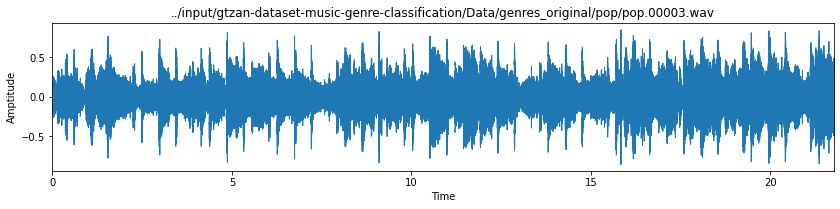

In [ ]:
print(type(sample),sample_rate)
sample, sample_rate = librosa.load(sample_audio, sr=16000)

# trazado de archivos de onda sin procesar, aquí está para el género Pop
fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot(211)
ax1.set_title("../input/gtzan-dataset-music-genre-classification/Data/genres_original/pop/pop.00003.wav")
ax1.set_xlabel('time')
ax1.set_ylabel('Amptitude')
librosa.display.waveplot(sample)
plt.show()

/usr/local/lib/python3.8/dist-packages/librosa/display.py:954: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  warnings.warn(


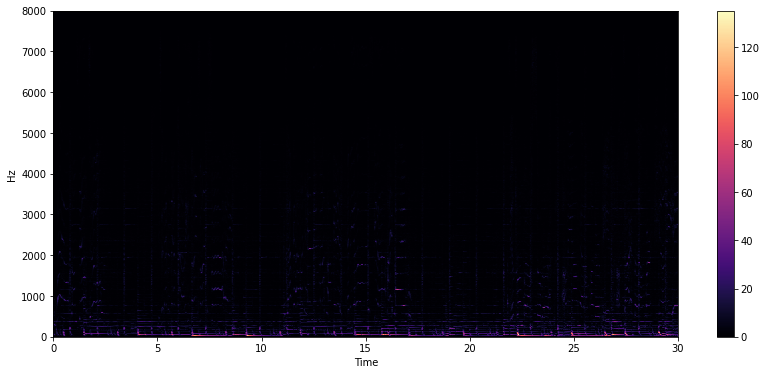

In [ ]:
# Espectrograma, tenemos esto en la carpeta de imágenes
# forma de representar el volumen de la señal en la frecuencia diferencial
# también conocido como ecografías
# cuando los datos son 3D, entonces cascada

stft = librosa.stft(sample)
stft_db = librosa.amplitude_to_db(abs(stft))
plt.figure(figsize=(14,6))
librosa.display.specshow(stft,sr=sample_rate,x_axis='time',y_axis='hz')
plt.colorbar()

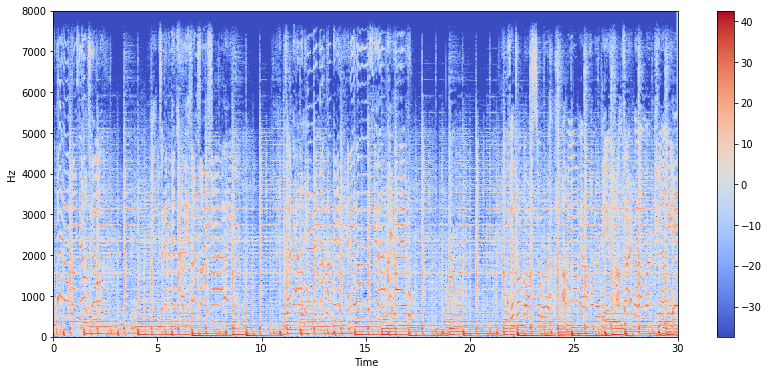

In [ ]:
stft = librosa.stft(sample)
stft_db = librosa.amplitude_to_db(abs(stft))
plt.figure(figsize=(14,6))
librosa.display.specshow(stft_db,sr=sample_rate,x_axis='time',y_axis='hz')
plt.colorbar()

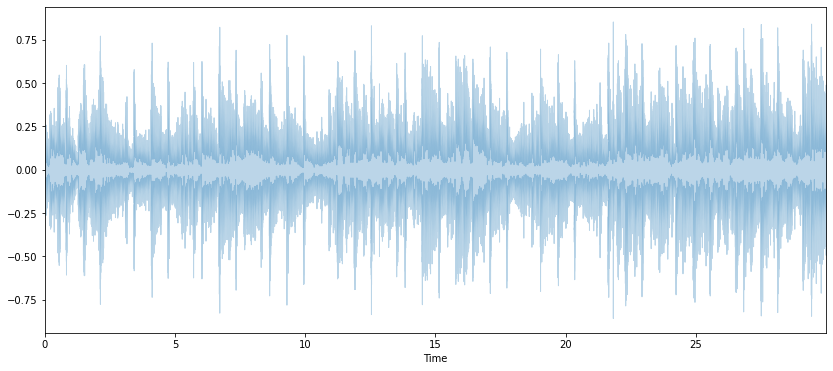

In [ ]:
# Rolloff - feq debajo del cual se encuentra un porcentaje específico del espectro total / 85%
from sklearn.preprocessing import normalize

spectral_rolloff = librosa.feature.spectral_rolloff(sample+0.01,sr=sample_rate)[0]
plt.figure(figsize=(14,6))
librosa.display.waveplot(sample,sr=sample_rate,alpha=0.3)

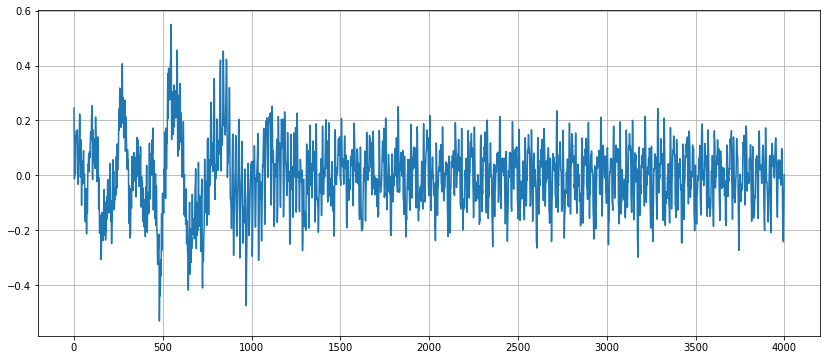

In [ ]:
# Zero crossing 
plt.figure(figsize=(14,6))
plt.plot(sample[8000:12000])
plt.grid()

In [ ]:
#count
zero_cross = librosa.zero_crossings(sample[8000:12000],pad=False)
print("Count {}".format(sum(zero_cross)))

Count 500


## 2. Feature Extraction


In [ ]:
class_list = dataf.iloc[:,-1] 
convert = LabelEncoder()
y = convert.fit_transform(class_list)
y

array([0, 0, 0, ..., 9, 9, 9])

In [ ]:
dataf.iloc[:,:-1]

,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
0,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,3714.560359,...,-2.853603,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767
1,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,3869.682242,...,4.074709,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081
2,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,3997.639160,...,4.806280,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122
3,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,3568.300218,...,-1.359111,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678
4,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,3469.992864,...,2.092937,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9985,66149,0.349126,0.080515,0.050019,0.000097,1499.083005,164266.886443,1718.707215,85931.574523,3015.559458,...,5.773784,42.485981,-9.094270,38.326839,-4.246976,31.049839,-5.625813,48.804092,1.818823,38.966969
9986,66149,0.372564,0.082626,0.057897,0.000088,1847.965128,281054.935973,1906.468492,99727.037054,3746.694524,...,2.074155,32.415203,-12.375726,66.418587,-3.081278,54.414265,-11.960546,63.452255,0.428857,18.697033
9987,66149,0.347481,0.089019,0.052403,0.000701,1346.157659,662956.246325,1561.859087,138762.841945,2442.362154,...,-1.005473,78.228149,-2.524483,21.778994,4.809936,25.980829,1.775686,48.582378,-0.299545,41.586990
9988,66149,0.387527,0.084815,0.066430,0.000320,2084.515327,203891.039161,2018.366254,22860.992562,4313.266226,...,4.123402,28.323744,-5.363541,17.209942,6.462601,21.442928,2.354765,24.843613,0.675824,12.787750


In [ ]:
# características de escala
from sklearn.preprocessing import StandardScaler
fit = StandardScaler()
X = fit.fit_transform(np.array(dataf.iloc[:,:-1],dtype=float))

# dividir en datos de entrenamiento y de prueba
X_train,x_test, Y_train, y_test = train_test_split(X,y,test_size=0.2)

print(len(Y_train),len(y_test))

7992 1998


## 3.Model Building

In [ ]:
# Usando el algoritmo CNN
from keras.models import Sequential
from keras.layers import Dense,Activation,Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# Construtendo el modelo

model = Sequential()

model.add(Dense(512,input_shape=(X_train.shape[1],),activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(256,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(64,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(10,activation='softmax'))


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               30208     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                8

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics='accuracy')
earlystop = EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=10,min_delta=0.0001)
modelcheck = ModelCheckpoint('best_model.hdf5',monitor='val_accuracy',verbose=1,save_best_only=True,mode='max')
history = model.fit(X_train,Y_train, validation_data=(x_test,y_test), epochs=600, callbacks=[earlystop,modelcheck], batch_size=128)

Epoch 1/600
61/63 [============================>.] - ETA: 0s - loss: 1.6285 - accuracy: 0.4075
Epoch 1: val_accuracy improved from -inf to 0.62462, saving model to best_model.hdf5
63/63 [==============================] - 4s 39ms/step - loss: 1.6223 - accuracy: 0.4105 - val_loss: 1.0862 - val_accuracy: 0.6246
Epoch 2/600
63/63 [==============================] - ETA: 0s - loss: 1.1107 - accuracy: 0.6147
Epoch 2: val_accuracy improved from 0.62462 to 0.72923, saving model to best_model.hdf5
63/63 [==============================] - 2s 24ms/step - loss: 1.1107 - accuracy: 0.6147 - val_loss: 0.8109 - val_accuracy: 0.7292
Epoch 3/600
60/63 [===========================>..] - ETA: 0s - loss: 0.8902 - accuracy: 0.6962
Epoch 3: val_accuracy improved from 0.72923 to 0.76326, saving model to best_model.hdf5
63/63 [==============================] - 2s 25ms/step - loss: 0.8897 - accuracy: 0.6981 - val_loss: 0.6902 - val_accuracy: 0.7633
Epoch 4/600
63/63 [==============================] - ETA: 0s - l

Epoch 00037: val_accuracy did not improve from 0.92543

Epoch 00037: early stopping

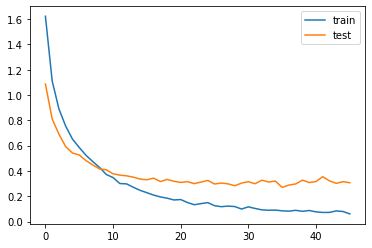

In [ ]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend()
pyplot.show()

In [ ]:
model.evaluate(x=x_test, y=y_test)

63/63 [==============================] - 0s 3ms/step - loss: 0.3067 - accuracy: 0.9184


[0.3066974878311157, 0.9184184074401855]

In [ ]:
#from keras.models import load_model
#Model = load_model("/content/drive/MyDrive/Universidad/AI/Final Project/best_model.hdf5")
test_loss, test_accuracy = model.evaluate(x_test,y_test,batch_size=128)
print("Test loss : ",test_loss)
print("\nBest test accuracy : ",test_accuracy*100)

16/16 [==============================] - 0s 6ms/step - loss: 0.3067 - accuracy: 0.9184
Test loss :  0.30669742822647095

Best test accuracy :  91.84184074401855
